In [13]:
# Import cleaned dataset
import datatable as dt
import pandas as pd
import numpy as np

df_train = dt.fread("df_train after DR.csv").to_pandas()
df_test = dt.fread("df_test after DR.csv").to_pandas()

In [14]:
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# Tuning multiple models with optuna

Credit:
https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e
https://stackoverflow.com/questions/56368785/running-gridsearch-over-voting-classifier
https://www.roelpeters.be/sklearn-pipeline-tutorial/
https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c
https://towardsdatascience.com/exploring-optuna-a-hyper-parameter-framework-using-logistic-regression-84bd622cd3a5

In [15]:
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, ShuffleSplit


# Define an objective function to be maximized.
def objective(trial, X_train, y_train, cv, scoring):
    regressors = trial.suggest_categorical('regressors', ['svr', 'decision_tree'])

    # Setup values for the hyperparameters:
    if regressors == 'svr':
        params = {'C': trial.suggest_categorical('C', [0.1, 1, 10, 100, 1000]),
                  'gamma': trial.suggest_categorical('gamma', [1, 0.1, 0.01, 0.001, 0.0001]),
                  'kernel': trial.suggest_categorical('kernel', ['rbf'])}
        model = SVR(**params)
    else:
        params = {'criterion': trial.suggest_categorical("criterion",
                                                         ['squared_error', 'friedman_mse', 'absolute_error',
                                                          'poisson']),
                  'max_depth': trial.suggest_int("max_depth", 2, 10, 2)
                  }
        model = DecisionTreeRegressor(**params)

    # Scoring method:
    score = cross_val_score(model, X_train, y_train, n_jobs=-1, cv=cv, scoring=scoring)
    return -score.mean()

In [16]:
ss = ShuffleSplit(n_splits=5, random_state=1)

# Create study that minimizes
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train, cv=ss, scoring='neg_mean_absolute_error'),
               n_trials=500)

[I 2021-11-21 16:00:06,766] A new study created in memory with name: no-name-80bd380d-d398-412d-91e6-0113468f02e9
[I 2021-11-21 16:00:34,286] Trial 0 finished with value: 2102004.088703663 and parameters: {'regressors': 'svr', 'C': 10, 'gamma': 1, 'kernel': 'rbf'}. Best is trial 0 with value: 2102004.088703663.
[I 2021-11-21 16:00:34,489] Trial 1 finished with value: 2215949.6320587904 and parameters: {'regressors': 'decision_tree', 'criterion': 'friedman_mse', 'max_depth': 2}. Best is trial 0 with value: 2102004.088703663.
[I 2021-11-21 16:00:35,033] Trial 2 finished with value: 2641530.0440979344 and parameters: {'regressors': 'decision_tree', 'criterion': 'poisson', 'max_depth': 10}. Best is trial 0 with value: 2102004.088703663.
[I 2021-11-21 16:00:35,357] Trial 3 finished with value: 1281285.413823335 and parameters: {'regressors': 'decision_tree', 'criterion': 'friedman_mse', 'max_depth': 6}. Best is trial 3 with value: 1281285.413823335.
[W 2021-11-21 16:00:35,497] Trial 4 faile

In [17]:
import pandas as pd

print('Five best values')
pd.options.display.float_format = '{:,.2f}'.format
study.trials_dataframe().sort_values('value', ascending=True).head(5)

Five best values


,number,value,datetime_start,datetime_complete,duration,params_C,params_criterion,params_gamma,params_kernel,params_max_depth,params_regressors,state
18,18,"1,131,281.81",2021-11-21 16:03:15.568842,2021-11-21 16:03:15.942731,0 days 00:00:00.373889,NaN,friedman_mse,NaN,NaN,8.00,decision_tree,COMPLETE
17,17,"1,131,961.40",2021-11-21 16:03:15.195712,2021-11-21 16:03:15.567842,0 days 00:00:00.372130,NaN,friedman_mse,NaN,NaN,8.00,decision_tree,COMPLETE
3,3,"1,281,285.41",2021-11-21 16:00:35.034865,2021-11-21 16:00:35.357111,0 days 00:00:00.322246,NaN,friedman_mse,NaN,NaN,6.00,decision_tree,COMPLETE
12,12,"2,100,741.71",2021-11-21 16:02:11.936545,2021-11-21 16:02:43.437879,0 days 00:00:31.501334,100.00,NaN,0.00,rbf,NaN,svr,COMPLETE
10,10,"2,100,893.95",2021-11-21 16:01:39.844077,2021-11-21 16:02:11.796140,0 days 00:00:31.952063,10.00,NaN,0.00,rbf,NaN,svr,COMPLETE


## This model is not chosen because its best validation loss is still greater than its counterpart of the Deep learning Linear model

In [18]:
trial = study.best_trial
print(f'Loss : {trial}')
print(f"Best hyperparameters: {trial.params}")

Loss : FrozenTrial(number=18, values=[1131281.805857507], datetime_start=datetime.datetime(2021, 11, 21, 16, 3, 15, 568842), datetime_complete=datetime.datetime(2021, 11, 21, 16, 3, 15, 942731), params={'regressors': 'decision_tree', 'criterion': 'friedman_mse', 'max_depth': 8}, distributions={'regressors': CategoricalDistribution(choices=('svr', 'decision_tree')), 'criterion': CategoricalDistribution(choices=('squared_error', 'friedman_mse', 'absolute_error', 'poisson')), 'max_depth': IntUniformDistribution(high=10, low=2, step=2)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=18, state=TrialState.COMPLETE, value=None)
Best hyperparameters: {'regressors': 'decision_tree', 'criterion': 'friedman_mse', 'max_depth': 8}


<ipython-input-19-e84322e291a0>:4: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(study);


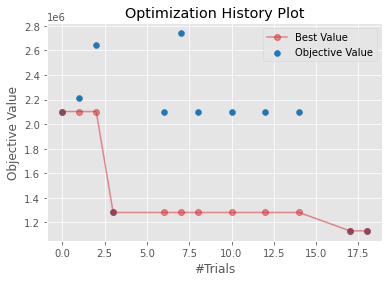

In [19]:
# plot the optimization history of the study
from optuna.visualization.matplotlib import plot_optimization_history

plot_optimization_history(study);

In [20]:
study.best_params

{'regressors': 'decision_tree', 'criterion': 'friedman_mse', 'max_depth': 8}

In [23]:
best_params = {key: value for key, value in study.best_params.items() if key != 'regressors'}
if study.best_params['regressors'] == 'decision_tree':
    best_model = DecisionTreeRegressor(**best_params)
else:
    best_model = SVR(**best_params)

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_value = pd.DataFrame({'ID': y_test.index, 'predicted_value': y_pred, 'actual_value': y_test})

In [24]:
y_pred_value.to_csv('Predicted value from Optuna.csv', index=False)